In [8]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np
import pickle
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
iMs_run = ['Arginine']
gene_int = 0

flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
flags_df = flags_df[flags_df['include'] == True]
true_false = []
for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
    if act in iMs_run or inh in iMs_run:
        true_false.append(True)
    else:
        true_false.append(False)
flags_df = flags_df.loc[true_false]
# setting up genes, promoter, and inhibitor
        
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder

t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'run_basal_calculations' : False, # it is very slow and should only be necessary to run if something has changed basal conditions
    'only_create_ratios' : False,
    'only_check_KdRNAPCrp' : False, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : 'purR', # only used for remove_outliers right now
    'drop_basal_conds' : True, # if True, removes basal conditions from sample after they're used to calculate ratios (useful when their outliers)
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3359'], #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}

#log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
log_tpm_df = pd.read_csv('../data/precise_1k/corrected/PRECISE_1K_log_tpm_basal.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

In [4]:
# multiprocess run
grid_steps = 3 # this is the default

genes = flags_df.index.to_list()
gene = genes[gene_int]
runs = []
run_to_grid_use = {}
gene_flags = []
for grid_use in range(0, grid_steps**2):
    # overall setup
    folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
    if len(folders) == 0:
        run_ct = 1
    else:
        run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
    new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
    os.mkdir(new_run_folder)

    # put the flags df in there
    flags_df.to_csv(new_run_folder+'/saved_flags.csv')
        
    # setup inputs
    runs.append(new_run_folder)
    run_to_grid_use.update({new_run_folder : grid_use})
    temp_flags = dict(flags_df.loc[gene])
    temp_flags.update({'grid_use' : grid_use})
    temp_flags.update({'central_gene' : gene})
    temp_flags.update({'grid_steps' : grid_steps})

    # need to convert some flags from strings to lists
    for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
        temp_flags[col] = ast.literal_eval(temp_flags[col])

    # convert cell constants into a dictionary
    temp_flags.update({'cell_constants' : {
        'RNAP' : stable_flags['cell_constants_RNAP'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
        'cell_volume' : stable_flags['cell_constants_cell_volume'],
        'kDeg' : stable_flags['cell_constants_kDeg'],
        'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
        'u' : stable_flags['cell_constants_u'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    }})
    temp_flags.update({'run_basal_calculations' : stable_flags['run_basal_calculations']})
    temp_flags.update({'eq_str' : stable_flags['eq_str']})
    temp_flags.update({'save_results' : stable_flags['save_results']})
    temp_flags.update({'save_results_folder' : new_run_folder})
    temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
    temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
    temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
    temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
    temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
    temp_flags.update({'case' : stable_flags['case']})
    temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})
    
    gene_flags.append(temp_flags)

# run pool
pool = multiprocessing.Pool(processes = 16)
results = pool.map(cdg.create_data_for_gene, gene_flags)
pool.close()
pool.join()

In [6]:
flags_df

,include,force_rerun,sanity_plots,act_iM,inh_iM,basal_conditions,grid_use,basal_bool,basal_or_hard_val,hard_val,...,lambda_,cxpb,cx_prob,mutpb,mt_prob,n_gen,verbose,n_iter,max_steps,n_rounds
central_gene,,,,,,,,,,,,,,,,,,,,,
b2818,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",8.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3959,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",7.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3958,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-2.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3359,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",7.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3957,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-1.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b0273,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-1.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3172,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-1.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b3960,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-1.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0
b4254,True,True,True,NaN,Arginine,"['p1k_00455', 'p1k_00456']",-1.0,False,basal,10.0,...,100.0,0.6,0.6,0.4,0.1,100.0,False,5.0,30.0,100.0


In [7]:
log_tpm_df

NameError: name 'log_tpm_df' is not defined

C:\Users\SBRG_2024\AppData\Local\Temp\ipykernel_20912\2472872540.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  dummy = plt.figure()


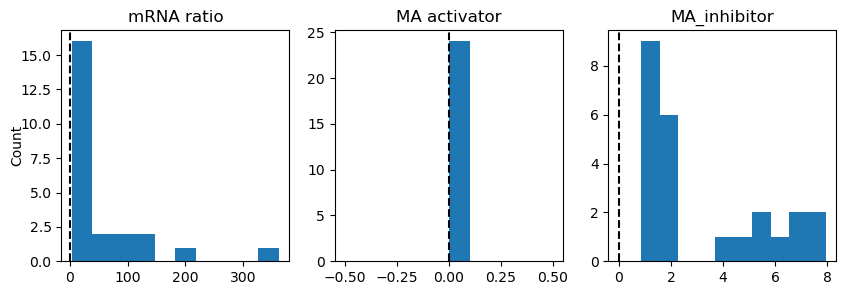

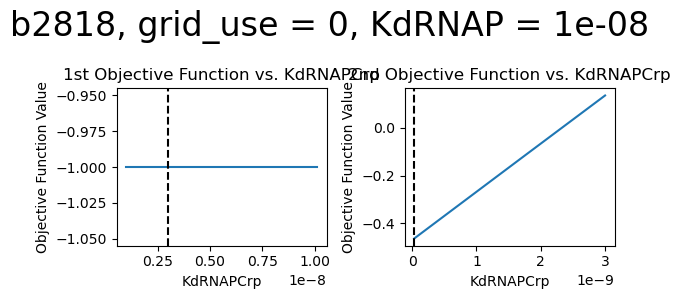

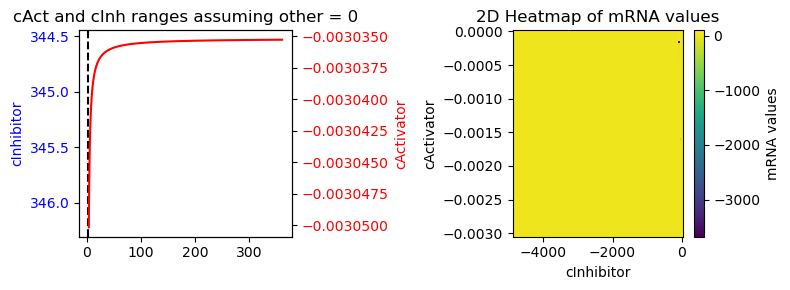

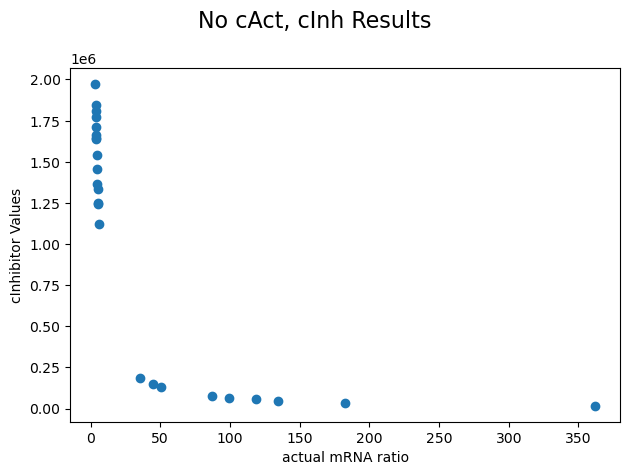

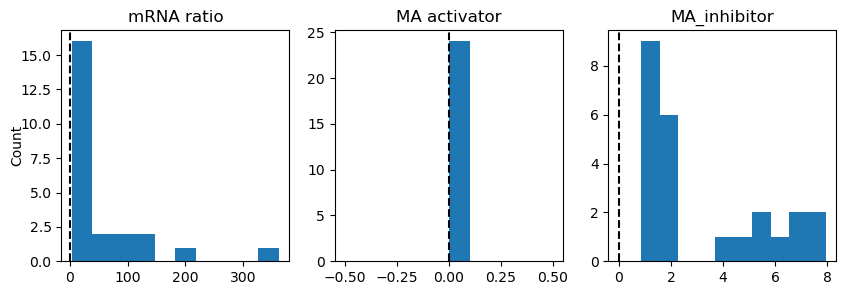

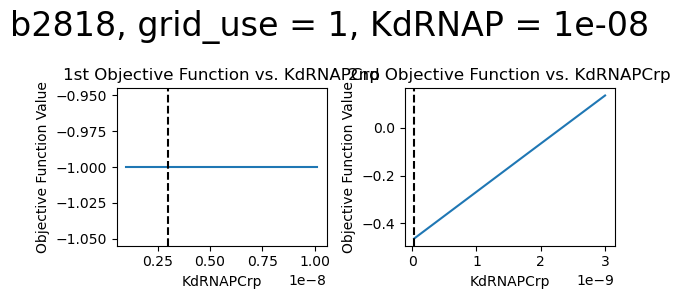

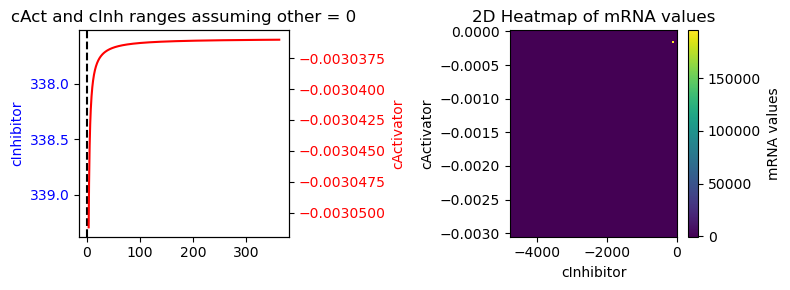

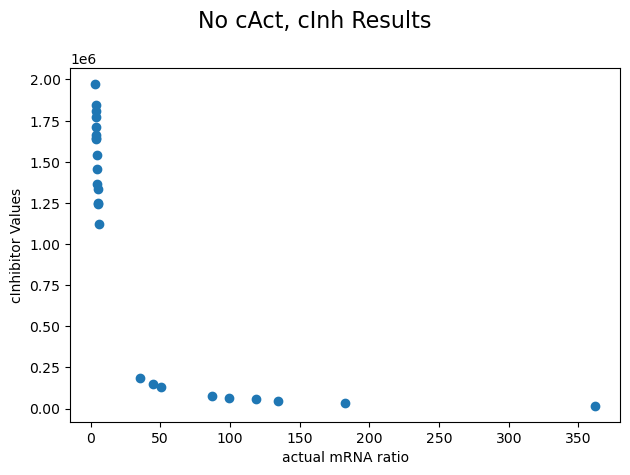

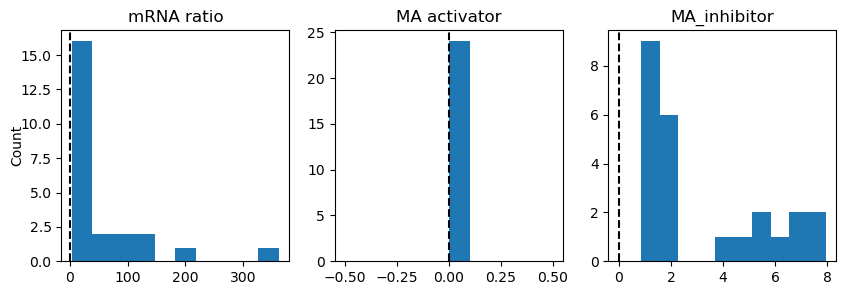

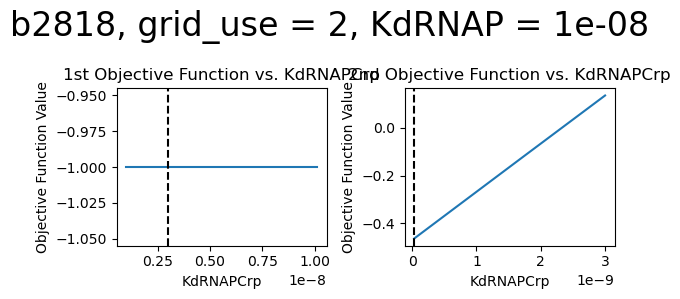

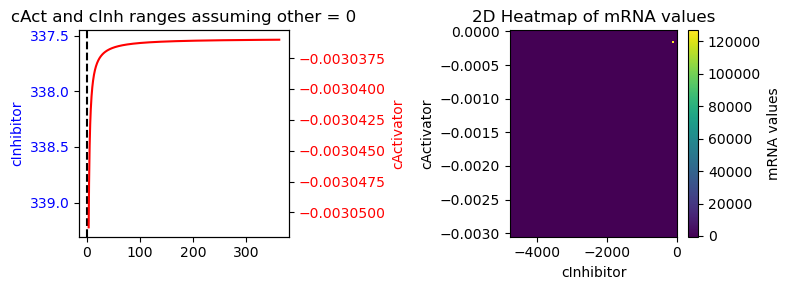

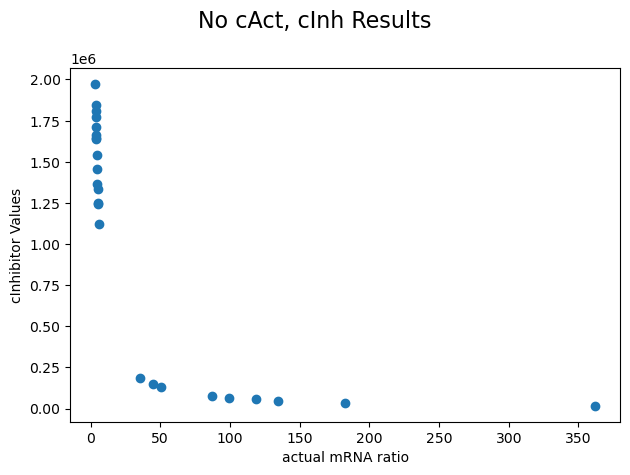

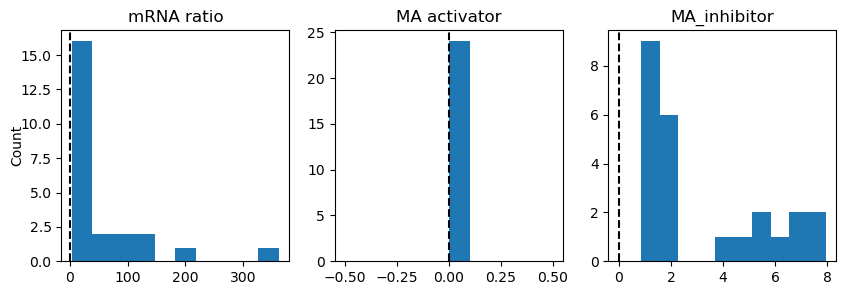

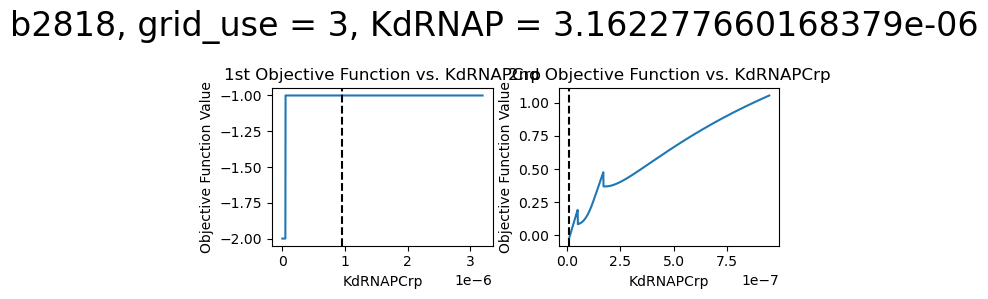

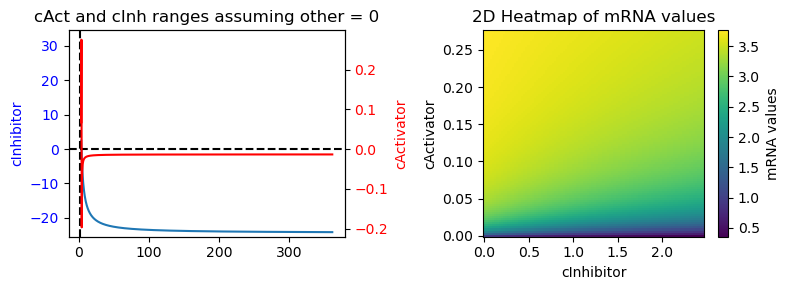

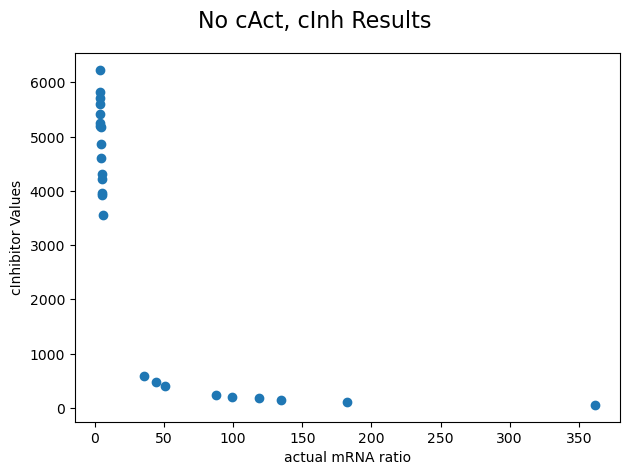

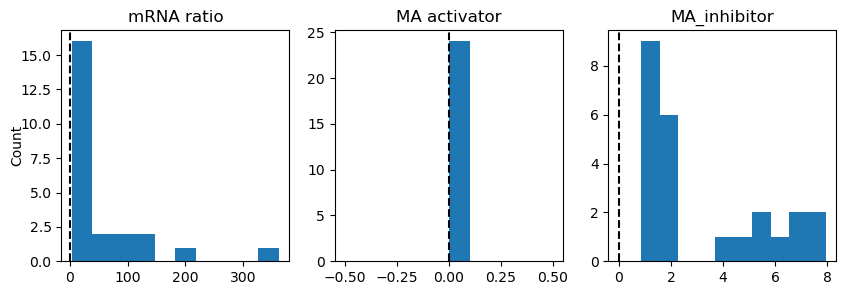

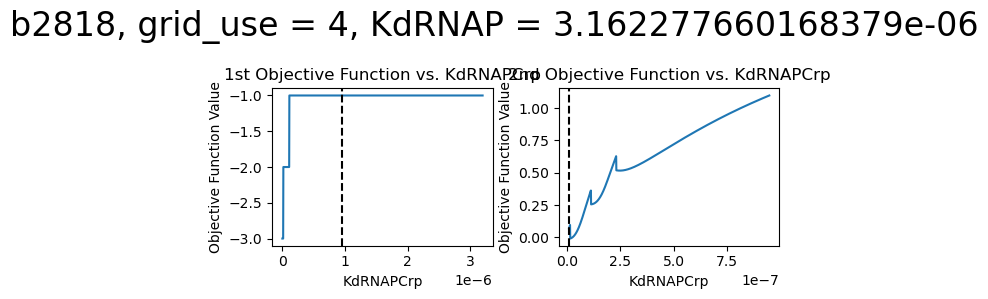

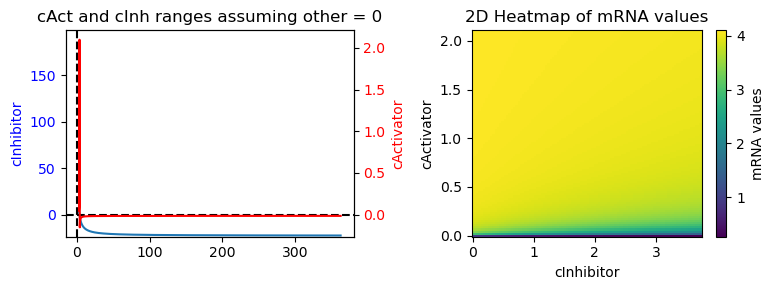

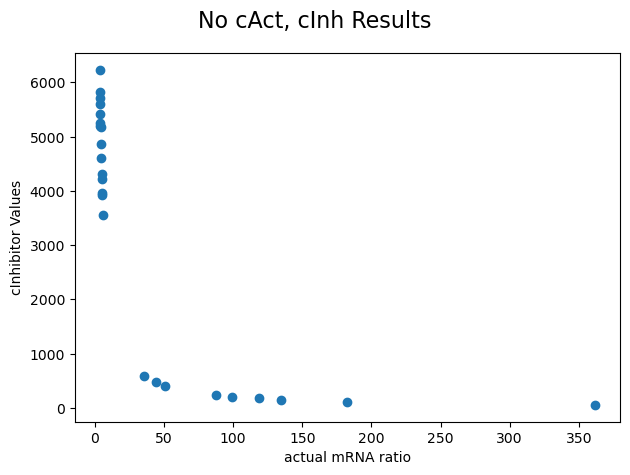

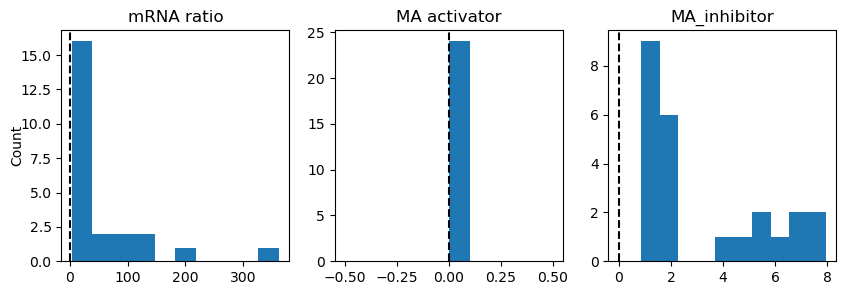

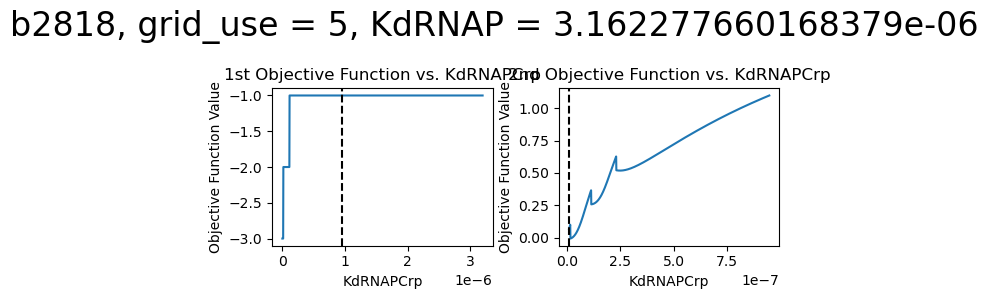

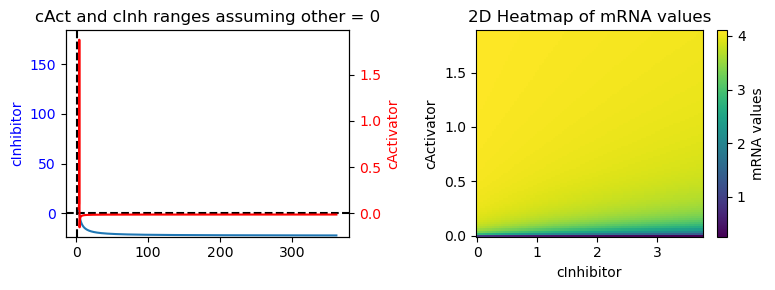

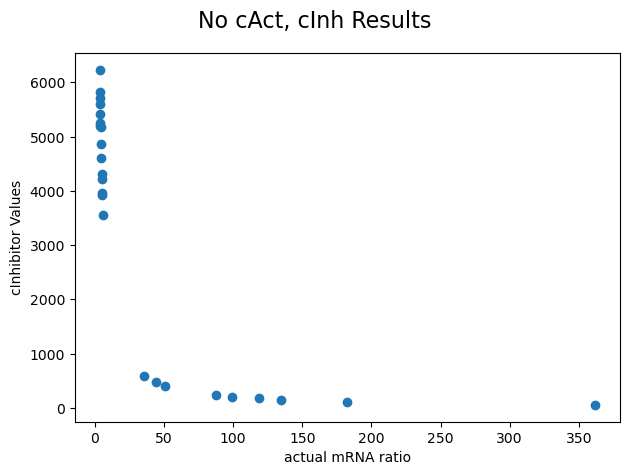

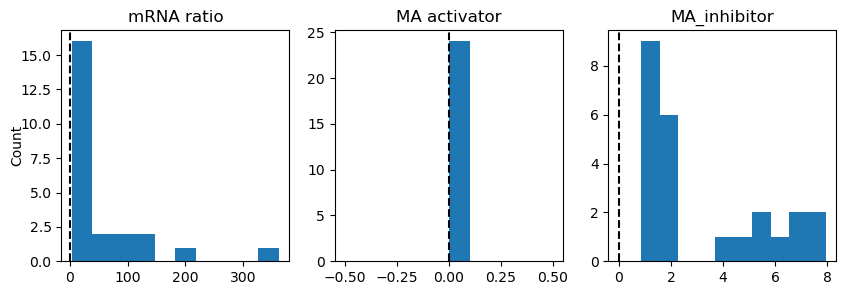

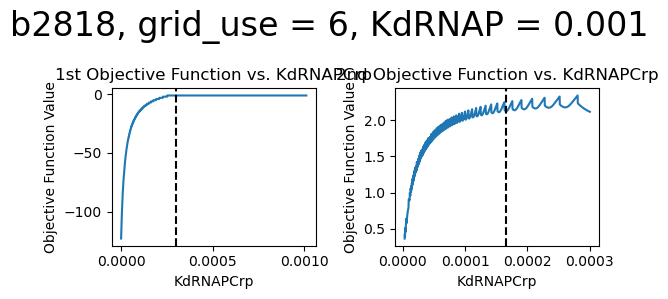

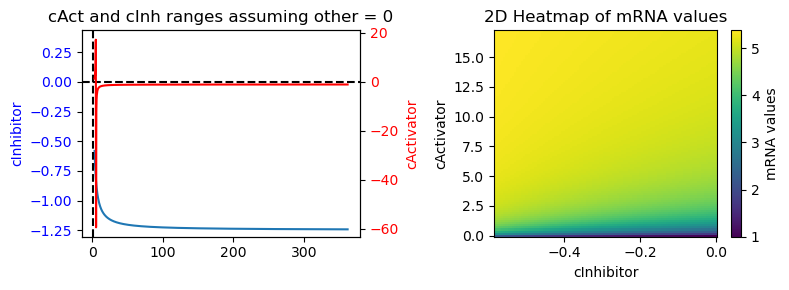

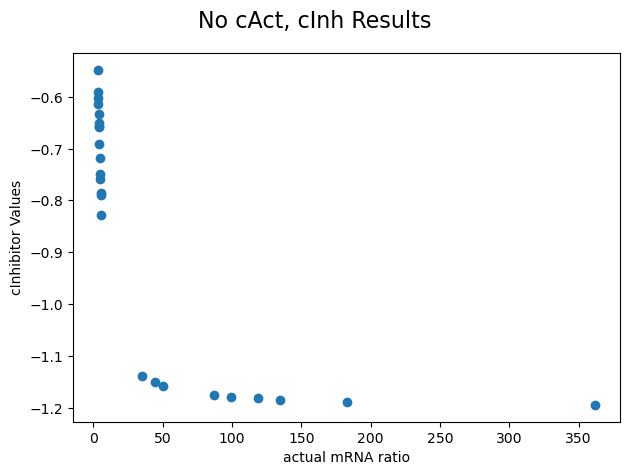

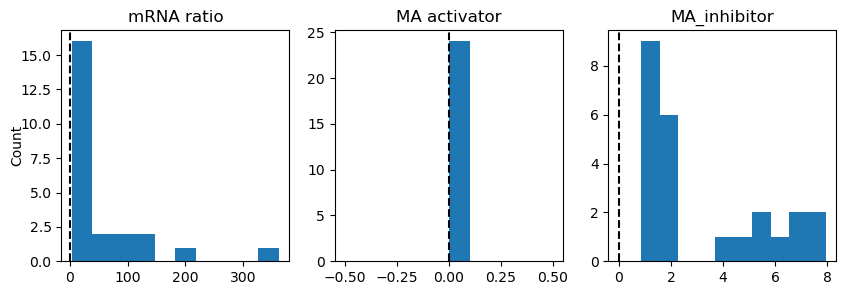

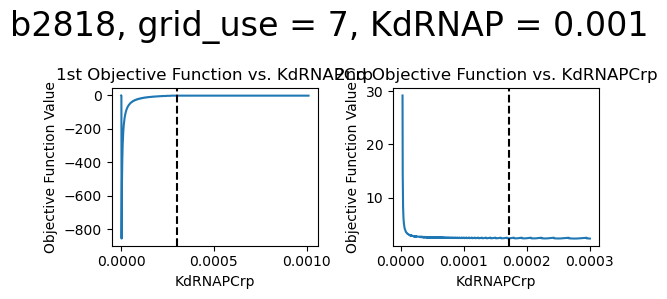

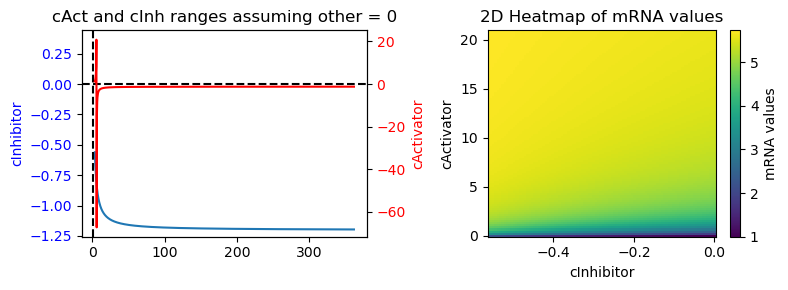

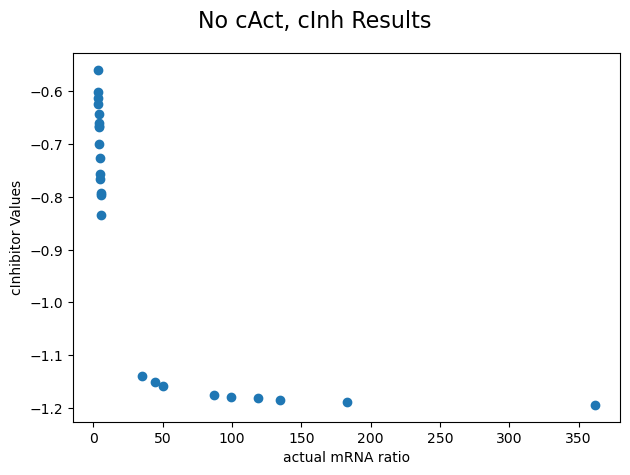

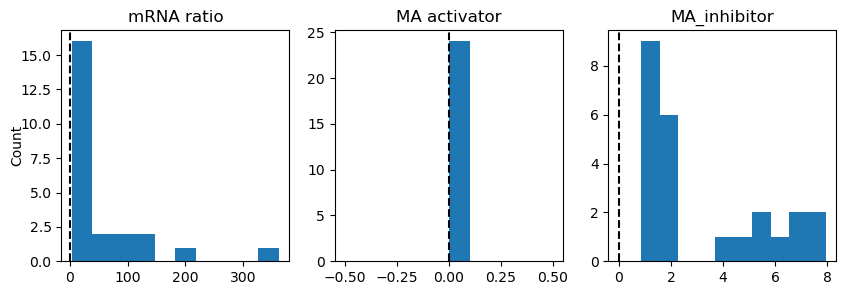

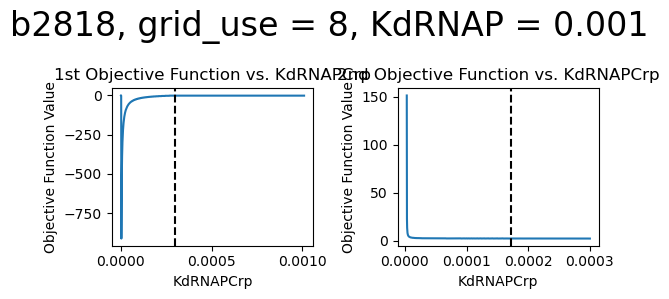

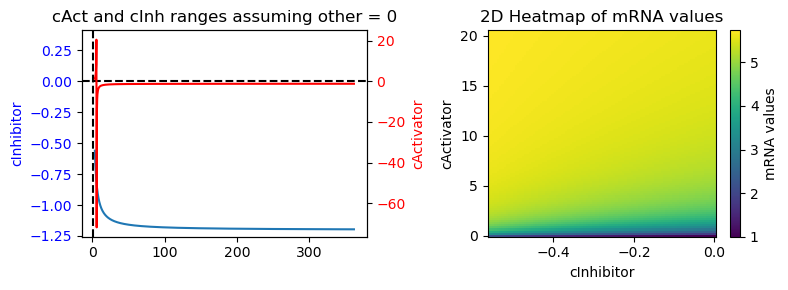

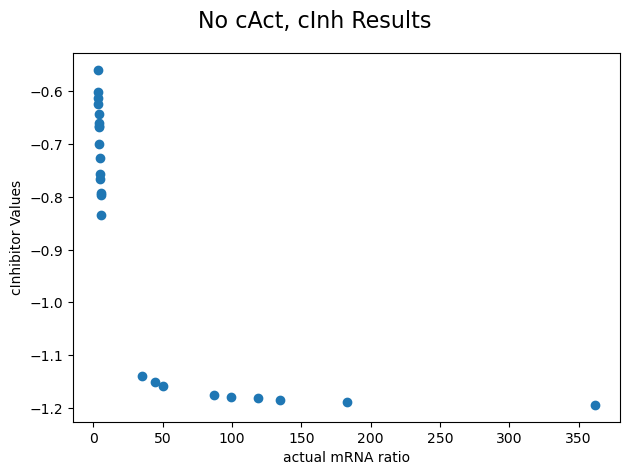

In [5]:
# display results
gene = genes[gene_int]
for new_run_folder in runs:
    grid_use = run_to_grid_use[new_run_folder]
    results = []
    pickle_in = open(new_run_folder+'/'+gene+'/figures.pkl', 'rb')
    results.append(pickle.load(pickle_in))
    pickle_in.close()
    cons_df = pd.read_pickle(new_run_folder+'/'+gene+'/constants.pkl')
    show_figure(results[0][0])
    for result in results:
        result[1].suptitle(gene+', grid_use = '+str(grid_use)+', KdRNAP = '+str(cons_df['KdRNAP']), fontsize = 24)
        result[1].tight_layout()
        for res in result[1:]:
            show_figure(res)
            #display(plt.gcf())

In [36]:
# KdRNAP values
for new_run_folder in runs:
    grid_use = run_to_grid_use[new_run_folder]
    if stable_flags['save_results']:
        results = []
        for gene in genes:
            pickle_in = open(new_run_folder+'/'+gene+'/figures.pkl', 'rb')
            results.append(pickle.load(pickle_in))
            pickle_in.close()
    cons_df = pd.read_pickle(new_run_folder+'/b2818/constants.pkl')
    print(cons_df['KdRNAP'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/saved_run_results/run_111/b2818/constants.pkl'